## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import re
import config as creds
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Connect to Postgres RDS

In [2]:
DATABASES = {
    'production':{
        'NAME': creds.PGDATABASE,
        'USER': creds.PGUSER,
        'PASSWORD': creds.PGPASSWORD,
        'HOST': creds.PGHOST,
        'PORT': 5432,
    },
}

#Choose the database to use
db = DATABASES['production']

In [3]:
#construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

## Load Data

In [4]:
#Create tables from database into pandas dataframe
parks_df = pd.read_sql_table('parks', engine)
species_df = pd.read_sql_table('species', engine)
visitation_df = pd.read_sql_table('visitation', engine)

In [5]:
print(parks_df.shape)
parks_df.head()

(56, 6)


,Park Code,Park Name,State,ACRES,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [6]:
print(species_df.shape)
species_df.head()

(119248, 13)


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,None
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,None,None
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,None,Species of Concern
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,None,None,Endangered
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,None


In [7]:
print(visitation_df.shape)
visitation_df.head()

(378, 12)


,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Acadia National Park,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
1,Arches National Park,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063
2,Badlands National Park,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227
3,Big Bend National Park,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154
4,Biscayne National Park,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950


### Explore the Data

In [8]:
#Explore the types of data in the species dataframe
species_df['Abundance'].unique().tolist()

['Rare',
 'Abundant',
 'Common',
 None,
 'Uncommon',
 'Occasional',
 'Unknown',
 'Not Native',
 'Native']

In [9]:
# THESE NEED FIXED 10 entries incorrect for species nativeness
test_df = species_df.loc[species_df['Abundance'] == 'Not Native'].copy()
test_df

test_df['Record Status'] = test_df['Occurance']
test_df['Occurance'] = test_df['Nativeness']
test_df['Nativeness'] = test_df['Abundance']
test_df['Abundance'] = test_df['Seasonality']
test_df['Seasonality'] = test_df['Conservation Status']
test_df

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
817,ACAD-1812,Acadia National Park,Vascular Plant,Caryophyllales,Caryophyllaceae,Agrostemma githago,Corn Cockle,Approved,Not Confirmed,Not Native,None,None,None
3287,BADL-1523,Badlands National Park,Vascular Plant,Brassicales,Brassicaceae,Hesperis matronalis,Dame's Rocket,Approved,Present,Not Native,Rare,None,None
45014,GRSA-1327,Great Sand Dunes National Park and Preserve,Fish,Salmoniformes,Salmonidae,Salvelinus fontinalis,Brook Trout,Approved,Present,Not Native,Common,Breeder,Breeder
45206,GRSA-1518,Great Sand Dunes National Park and Preserve,Vascular Plant,Caryophyllales,Amaranthaceae,Chenopodium album,Lamb's Quarters,Approved,Present,Not Native,Rare,None,None
45261,GRSA-1572,Great Sand Dunes National Park and Preserve,Vascular Plant,Caryophyllales,Portulacaceae,Portulaca oleracea,Common Purslane,Approved,Not Confirmed,Not Native,None,None,None
45331,GRSA-1643,Great Sand Dunes National Park and Preserve,Vascular Plant,Geraniales,Geraniaceae,Erodium cicutarium,Filaree,Approved,Present,Not Native,Rare,None,None
45371,GRSA-1682,Great Sand Dunes National Park and Preserve,Vascular Plant,Lamiales,Scrophulariaceae,Verbascum thapsus,Great Mullein,Approved,Not Confirmed,Not Native,None,None,None
45495,GRSA-1805,Great Sand Dunes National Park and Preserve,Vascular Plant,Poales,Poaceae,Bromus tectorum,Cheatgrass,Approved,Present,Not Native,Rare,None,None
53437,GRTE-2135,Grand Teton National Park,Vascular Plant,Geraniales,Geraniaceae,Erodium cicutarium,Storksbill,Approved,Present,Not Native,Uncommon,None,None
98533,SAGU-2429,Saguaro National Park,Vascular Plant,Poales,Cyperaceae,Cyperus rotundus,Purple Nut Grass,Approved,Present,Not Native,Unknown,None,None


In [10]:
# THESE NEED FIXED 40 entries incorrect for species nativeness
test_df_2 = species_df.loc[species_df['Abundance'] == 'Native'].copy()

test_df_2['Record Status'] = test_df_2['Occurance']
test_df_2['Occurance'] = test_df_2['Nativeness']
test_df_2['Nativeness'] = test_df_2['Abundance']
test_df_2['Abundance'] = test_df_2['Seasonality']
test_df_2['Seasonality'] = test_df_2['Conservation Status']
test_df_2

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
27516,DEVA-2399,Death Valley National Park,Vascular Plant,Boraginales,Boraginaceae,Amsinckia menziesii,Fiddleneck,Approved,Present,Native,Unknown,None,None
31836,EVER-1414,Everglades National Park,Reptile,Crocodilia,Crocodylidae,Crocodylus acutus,American Crocodile,Approved,Present,Native,Uncommon,Resident,Resident
31876,EVER-1454,Everglades National Park,Reptile,Testudines,Cheloniidae,Caretta caretta,Loggerhead,Approved,Present,Native,Rare,Breeder,Breeder
44688,GRSA-1003,Great Sand Dunes National Park and Preserve,Mammal,Artiodactyla,Cervidae,Cervus elaphus,American Elk,Approved,Present,Native,Rare,Migratory,Migratory
44698,GRSA-1013,Great Sand Dunes National Park and Preserve,Mammal,Carnivora,Mustelidae,Mustela erminea,Ermine,Approved,Present,Native,Rare,Migratory,Migratory
44728,GRSA-1043,Great Sand Dunes National Park and Preserve,Mammal,Rodentia,Cricetidae,Peromyscus maniculatus,Deer Mouse,Approved,Present,Native,Rare,Breeder,Breeder
44754,GRSA-1069,Great Sand Dunes National Park and Preserve,Bird,Accipitriformes,Accipitridae,Accipiter gentilis,Goshawk,Approved,Present,Native,Rare,Breeder,Breeder
44766,GRSA-1081,Great Sand Dunes National Park and Preserve,Bird,Anseriformes,Anatidae,Anas acuta,Pintail,Approved,Present,Native,Rare,Resident,Resident
44793,GRSA-1108,Great Sand Dunes National Park and Preserve,Bird,Caprimulgiformes,Caprimulgidae,Phalaenoptilus nuttallii,Poor-Will,Approved,Present,Native,Uncommon,Breeder,Breeder
44822,GRSA-1136,Great Sand Dunes National Park and Preserve,Bird,Falconiformes,Falconidae,Falco columbarius,Merlin,Approved,Present,Native,Rare,Resident,Resident


In [11]:
#Replace columns in the species_df with the corrected Nativeness columns
species_df.update(test_df)
species_df.update(test_df_2)
species_df.head()

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,None
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,None,None
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,None,Species of Concern
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,None,None,Endangered
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,None


In [12]:
species_df['Nativeness'].unique().tolist()

['Native', 'Not Native', 'Unknown', None, 'Present']

In [13]:
species_df['Abundance'].unique().tolist()

['Rare',
 'Abundant',
 'Common',
 None,
 'Uncommon',
 'Occasional',
 'Unknown',
 'Not Native',
 'Native']

In [14]:
#Explore the types of categories in the species data frame
species_df['Category'].unique().tolist()

['Mammal',
 'Vascular Plant',
 'Bird',
 'Reptile',
 'Amphibian',
 'Fish',
 'Insect',
 'Spider/Scorpion',
 'Invertebrate',
 'Fungi',
 'Nonvascular Plant',
 'Algae',
 'Crab/Lobster/Shrimp',
 'Slug/Snail']

In [15]:
#Describe the data columns in species_df
species_df.describe(include='all')

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
count,119248,119248,119248,117776,117736,119248,119248,119248,99106,94203,76306,20157,4718
unique,119248,56,14,554,2332,46022,35825,4,7,4,8,24,11
top,GUMO-1545,Great Smoky Mountains National Park,Vascular Plant,Poales,Asteraceae,Falco peregrinus,None,Approved,Present,Native,Unknown,Breeder,Species of Concern
freq,1,6623,65221,11453,8843,56,27147,86304,83324,75990,28121,12221,3843


In [16]:
#Describe the ACREAGE data from the parks database
parks_df.ACRES.describe()

count    5.600000e+01
mean     9.279291e+05
std      1.709258e+06
min      5.550000e+03
25%      6.901050e+04
50%      2.387645e+05
75%      8.173602e+05
max      8.323148e+06
Name: ACRES, dtype: float64

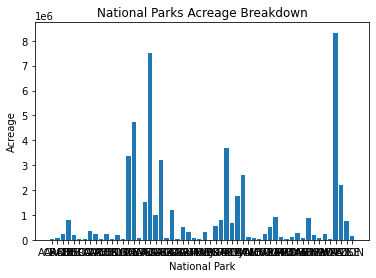

In [17]:
#Bar Chart showing acreage of parks
parks = parks_df['Park Code']
acreage = parks_df['ACRES']

x_pos = [i for i, _ in enumerate(parks)]
plt.bar(x_pos, acreage)
plt.xlabel("National Park")
plt.ylabel("Acreage")
plt.title("National Parks Acreage Breakdown")

plt.xticks(x_pos,parks)

plt.show()

In [18]:
#Explore binning the acreage of parks into four bins
pd.qcut(parks_df['ACRES'], q=4)

0        (5549.999, 69010.5]
1        (69010.5, 238764.5]
2      (238764.5, 817360.25]
3      (238764.5, 817360.25]
4        (69010.5, 238764.5]
5        (5549.999, 69010.5]
6        (5549.999, 69010.5]
7      (238764.5, 817360.25]
8      (238764.5, 817360.25]
9        (5549.999, 69010.5]
10     (238764.5, 817360.25]
11       (5549.999, 69010.5]
12       (69010.5, 238764.5]
13       (5549.999, 69010.5]
14    (817360.25, 8323148.0]
15    (817360.25, 8323148.0]
16       (5549.999, 69010.5]
17    (817360.25, 8323148.0]
18    (817360.25, 8323148.0]
19    (817360.25, 8323148.0]
20    (817360.25, 8323148.0]
21       (69010.5, 238764.5]
22    (817360.25, 8323148.0]
23       (5549.999, 69010.5]
24     (238764.5, 817360.25]
25     (238764.5, 817360.25]
26       (69010.5, 238764.5]
27       (5549.999, 69010.5]
28     (238764.5, 817360.25]
29       (5549.999, 69010.5]
30     (238764.5, 817360.25]
31     (238764.5, 817360.25]
32    (817360.25, 8323148.0]
33     (238764.5, 817360.25]
34    (817360.

## Transform Data

In [19]:
#Convert park names to list object from vistation dataframe
park_name_list = visitation_df.iloc[:,0]
park_name_list

0        Acadia National Park
1        Arches National Park
2      Badlands National Park
3      Big Bend National Park
4      Biscayne National Park
                ...          
373         Wilson's Creek NB
374        Women's Rights NHP
375     World War II Memorial
376      Wright Brothers NMEM
377                Wupatki NM
Name: Park Name, Length: 378, dtype: object

In [20]:
#Replace abbreviations in list
park_name_list = park_name_list.str.replace("Wrangell-St. Elias NP & PRES", "Wrangell - St Elias National Park and Preserve")
park_name_list = park_name_list.str.replace("Gates of the Arctic NP & PRES", "Gates Of The Arctic National Park and Preserve")
park_name_list = park_name_list.str.replace(" NP & PRES", " National Park and Preserve")
park_name_list = park_name_list.str.replace(" NPRES", " National Preserve")
park_name_list = park_name_list.str.replace(" NP", " National Park")
park_name_list = park_name_list.str.replace(" NM", " National Monument")
park_name_list = park_name_list.str.replace(" NHP", " National Historic Place")
park_name_list

C:\Users\ohugh\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0                        Acadia National Park
1                        Arches National Park
2                      Badlands National Park
3                      Big Bend National Park
4                      Biscayne National Park
                        ...                  
373                         Wilson's Creek NB
374    Women's Rights National Historic Place
375                     World War II Memorial
376       Wright Brothers National MonumentEM
377                 Wupatki National Monument
Name: Park Name, Length: 378, dtype: object

In [21]:
#Replace visitaiton_df "Park Name" column with updated park names
visitation_df["Park Name"] = park_name_list
visitation_df.head()

,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Acadia National Park,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
1,Arches National Park,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063
2,Badlands National Park,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227
3,Big Bend National Park,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154
4,Biscayne National Park,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950


In [22]:
#Append a row to the dataframe for Sequoia and Kings Canyon National Park
visitation_df.loc[len(visitation_df.index)] = ["Sequoia and Kings Canyon National Parks", 1573393, 1697617, 1476818, 1541405, 1565570, 1862167, 1984188, 1928617, 1878163, 1211163, 1671910]
visitation_df.tail()

,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
374,Women's Rights National Historic Place,22662.0,25426.0,29585.0,30137.0,30254.0,38139.0,52683.0,61806,42784,39064,37254
375,World War II Memorial,3964351.0,3752172.0,4161685.0,3934166.0,4230793.0,5068224.0,4856532.0,4876842,4652865,4831327,4432896
376,Wright Brothers National MonumentEM,476200.0,445455.0,466816.0,447796.0,430517.0,437184.0,458776.0,414244,360669,400135,433779
377,Wupatki National Monument,221083.0,216165.0,201365.0,190878.0,195962.0,212828.0,223172.0,236454,205122,187059,209009
378,Sequoia and Kings Canyon National Parks,1573393.0,1697617.0,1476818.0,1541405.0,1565570.0,1862167.0,1984188.0,1928617,1878163,1211163,1671910


In [23]:
# Set index on dataframes to Park Names
parks_df.set_index("Park Name", inplace=True, drop=True)
species_df.set_index("Park Name", inplace=True, drop=True)
visitation_df.set_index("Park Name", inplace=True, drop=True)

print(parks_df)
print(visitation_df)

                                               Park Code       State    ACRES  \
Park Name                                                                       
Acadia National Park                                ACAD          ME    47390   
Arches National Park                                ARCH          UT    76519   
Badlands National Park                              BADL          SD   242756   
Big Bend National Park                              BIBE          TX   801163   
Biscayne National Park                              BISC          FL   172924   
Black Canyon of the Gunnison National Park          BLCA          CO    32950   
Bryce Canyon National Park                          BRCA          UT    35835   
Canyonlands National Park                           CANY          UT   337598   
Capitol Reef National Park                          CARE          UT   241904   
Carlsbad Caverns National Park                      CAVE          NM    46766   
Channel Islands National Par

In [24]:
#Perform left join on parks df with visitaiton df
park_visitation_df = parks_df.join(visitation_df)
park_visitation_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
Park Name,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,209166.0,238018.0,307143,308962,432818,239225
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,1745804.0,2365110.0,2571684,2679478,2594904,1867144
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,634607.0,776218.0,742271,739449,733996,599385
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,941029.0,1064904.0,1150165,1227627,1226519,906527


In [25]:
#Check shape of dataframe
park_visitation_df.shape

(57, 16)

In [26]:
#Check for null values
park_visitation_df.isnull().sum()

Park Code    0
State        0
ACRES        0
Latitude     0
Longitude    0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
Average      0
dtype: int64

In [27]:
#Count the number of native and non-native species for each park
native_species_grouped = species_df.groupby(['Park Name', 'Nativeness']).agg({'Nativeness': ['count']})
native_species_grouped.columns = ['Nativeness_count']
native_species_grouped = native_species_grouped.reset_index()
print(native_species_grouped)
print(type(native_species_grouped))

                  Park Name  Nativeness  Nativeness_count
0      Acadia National Park      Native              1189
1      Acadia National Park  Not Native               486
2      Acadia National Park     Unknown                33
3      Arches National Park      Native               939
4      Arches National Park  Not Native               108
..                      ...         ...               ...
158  Yosemite National Park  Not Native               207
159  Yosemite National Park     Unknown                10
160      Zion National Park      Native              1591
161      Zion National Park  Not Native               203
162      Zion National Park     Unknown                 2

[163 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [28]:
#Reshape dataframe and re-index to merge with main dataframe
nativeness_df = native_species_grouped.pivot(index='Park Name', columns='Nativeness')
nativeness_df.columns = nativeness_df.columns.droplevel()
nativeness_df = nativeness_df.drop(columns=['Present'])
nativeness_df.head()

Nativeness,Native,Not Native,Unknown
Park Name,,,
Acadia National Park,1189.0,486.0,33.0
Arches National Park,939.0,108.0,1.0
Badlands National Park,779.0,100.0,35.0
Big Bend National Park,2108.0,112.0,9.0
Biscayne National Park,751.0,241.0,620.0


In [29]:
#Merge parks dataframe with species nativeness
combined_dataframe = park_visitation_df.join(nativeness_df)
combined_dataframe

#Replace NaN with 0
replace_null_df = combined_dataframe.replace(np.nan,0)
replace_null_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average,Native,Not Native,Unknown
Park Name,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667,1189.0,486.0,33.0
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063,939.0,108.0,1.0
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227,779.0,100.0,35.0
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154,2108.0,112.0,9.0
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950,751.0,241.0,620.0
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,209166.0,238018.0,307143,308962,432818,239225,975.0,130.0,1.0
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,1745804.0,2365110.0,2571684,2679478,2594904,1867144,1186.0,98.0,2.0
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,634607.0,776218.0,742271,739449,733996,599385,1103.0,120.0,0.0
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,941029.0,1064904.0,1150165,1227627,1226519,906527,1406.0,158.0,2.0


In [30]:
#Create field for total number of species and sum two previous columns in dataframe
replace_null_df['total_species'] = replace_null_df['Native'] + replace_null_df['Not Native'] + replace_null_df['Unknown']
replace_null_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average,Native,Not Native,Unknown,total_species
Park Name,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667,1189.0,486.0,33.0,1708.0
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063,939.0,108.0,1.0,1048.0
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227,779.0,100.0,35.0,914.0
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154,2108.0,112.0,9.0,2229.0
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950,751.0,241.0,620.0,1612.0
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,209166.0,238018.0,307143,308962,432818,239225,975.0,130.0,1.0,1106.0
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,1745804.0,2365110.0,2571684,2679478,2594904,1867144,1186.0,98.0,2.0,1286.0
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,634607.0,776218.0,742271,739449,733996,599385,1103.0,120.0,0.0,1223.0
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,941029.0,1064904.0,1150165,1227627,1226519,906527,1406.0,158.0,2.0,1566.0


In [31]:
#Calculate the ratio of native to non-native species and add as a  column in the dataframe
replace_null_df['NonNative_Ratio'] = replace_null_df['Not Native'] / replace_null_df['total_species']
biodiversity_clean_df = replace_null_df
biodiversity_clean_df.head()

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,Average,Native,Not Native,Unknown,total_species,NonNative_Ratio
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,...,3303393.0,3509271,3537575,3437286,2872667,1189.0,486.0,33.0,1708.0,0.284543
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,...,1585718.0,1539028,1663557,1659702,1334063,939.0,108.0,1.0,1048.0,0.103053
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,...,996263.0,1054325,1008942,970998,951227,779.0,100.0,35.0,914.0,0.109409
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,...,388290.0,440276,440091,463832,377154,2108.0,112.0,9.0,2229.0,0.050247
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,...,514709.0,446961,469253,708522,509950,751.0,241.0,620.0,1612.0,0.149504


In [32]:
#Group categories of species
species_categories_grouped = species_df.groupby(['Park Name', 'Category']).agg({'Category': ['count']})
species_categories_grouped.columns = ['Category Count']
species_categories_grouped = species_categories_grouped.reset_index()
print(species_categories_grouped)
print(type(species_categories_grouped))

                Park Name        Category  Category Count
0    Acadia National Park       Amphibian              15
1    Acadia National Park            Bird             364
2    Acadia National Park            Fish              38
3    Acadia National Park          Mammal              55
4    Acadia National Park         Reptile              11
..                    ...             ...             ...
544    Zion National Park            Bird             301
545    Zion National Park            Fish              15
546    Zion National Park          Mammal              80
547    Zion National Park         Reptile              30
548    Zion National Park  Vascular Plant            1363

[549 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [33]:
#Reshape dataframe and re-index to merge with main dataframe
categories_df = species_categories_grouped.pivot(index='Park Name', columns='Category')
categories_df.columns = categories_df.columns.droplevel()
categories_df

#Replace NaN with 0
categories_df = categories_df.replace(np.nan,0)
categories_df

Category,Algae,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant
Park Name,,,,,,,,,,,,,,
Acadia National Park,0.0,15.0,364.0,0.0,38.0,0.0,0.0,0.0,55.0,0.0,11.0,0.0,0.0,1226.0
Arches National Park,0.0,8.0,205.0,0.0,11.0,0.0,0.0,0.0,59.0,0.0,20.0,0.0,0.0,745.0
Badlands National Park,0.0,10.0,239.0,0.0,24.0,173.0,239.0,1.0,64.0,0.0,13.0,0.0,1.0,625.0
Big Bend National Park,0.0,13.0,415.0,0.0,53.0,0.0,0.0,0.0,89.0,48.0,62.0,0.0,0.0,1589.0
Biscayne National Park,0.0,8.0,233.0,0.0,818.0,0.0,11.0,34.0,28.0,0.0,40.0,0.0,0.0,554.0
Black Canyon of the Gunnison National Park,0.0,2.0,175.0,0.0,16.0,0.0,0.0,0.0,67.0,0.0,11.0,0.0,0.0,835.0
Bryce Canyon National Park,0.0,4.0,217.0,0.0,1.0,0.0,0.0,0.0,76.0,0.0,13.0,0.0,0.0,975.0
Canyonlands National Park,0.0,7.0,220.0,0.0,33.0,0.0,0.0,0.0,76.0,0.0,22.0,0.0,0.0,865.0
Capitol Reef National Park,0.0,6.0,248.0,0.0,15.0,0.0,0.0,0.0,73.0,0.0,21.0,0.0,0.0,1203.0


In [34]:
#Join data to biodiversity cleaned dataframe
biodiversity_clean_df = biodiversity_clean_df.join(categories_df)
biodiversity_clean_df.head()

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,...,Fish,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,...,38.0,0.0,0.0,0.0,55.0,0.0,11.0,0.0,0.0,1226.0
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,...,11.0,0.0,0.0,0.0,59.0,0.0,20.0,0.0,0.0,745.0
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,...,24.0,173.0,239.0,1.0,64.0,0.0,13.0,0.0,1.0,625.0
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,...,53.0,0.0,0.0,0.0,89.0,48.0,62.0,0.0,0.0,1589.0
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,...,818.0,0.0,11.0,34.0,28.0,0.0,40.0,0.0,0.0,554.0


In [35]:
#Add a column in the dataframe on the ratio of non-native to native species
biodiversity_clean_df['NonNative_to_Native_Ratio'] = biodiversity_clean_df['Not Native'] / biodiversity_clean_df['Native']
biodiversity_clean_df.head()

#Drop year columns
biodiversity_clean_df = biodiversity_clean_df.drop(columns =['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])
biodiversity_clean_df

,Park Code,State,ACRES,Latitude,Longitude,Average,Native,Not Native,Unknown,total_species,...,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,NonNative_to_Native_Ratio
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2872667,1189.0,486.0,33.0,1708.0,...,0.0,0.0,0.0,55.0,0.0,11.0,0.0,0.0,1226.0,0.408747
Arches National Park,ARCH,UT,76519,38.68,-109.57,1334063,939.0,108.0,1.0,1048.0,...,0.0,0.0,0.0,59.0,0.0,20.0,0.0,0.0,745.0,0.115016
Badlands National Park,BADL,SD,242756,43.75,-102.50,951227,779.0,100.0,35.0,914.0,...,173.0,239.0,1.0,64.0,0.0,13.0,0.0,1.0,625.0,0.128370
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,377154,2108.0,112.0,9.0,2229.0,...,0.0,0.0,0.0,89.0,48.0,62.0,0.0,0.0,1589.0,0.053131
Biscayne National Park,BISC,FL,172924,25.65,-80.08,509950,751.0,241.0,620.0,1612.0,...,0.0,11.0,34.0,28.0,0.0,40.0,0.0,0.0,554.0,0.320905
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,239225,975.0,130.0,1.0,1106.0,...,0.0,0.0,0.0,67.0,0.0,11.0,0.0,0.0,835.0,0.133333
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1867144,1186.0,98.0,2.0,1286.0,...,0.0,0.0,0.0,76.0,0.0,13.0,0.0,0.0,975.0,0.082631
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,599385,1103.0,120.0,0.0,1223.0,...,0.0,0.0,0.0,76.0,0.0,22.0,0.0,0.0,865.0,0.108794
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,906527,1406.0,158.0,2.0,1566.0,...,0.0,0.0,0.0,73.0,0.0,21.0,0.0,0.0,1203.0,0.112376


In [39]:
#Save dataframe to postgres table  
biodiversity_clean_df.to_sql("biodiversity_df", engine, index=True)